In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import math
from scipy import stats
import acquire as a
import prepare as p

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

### Stakeholder:

VP of Product: Which product line should we expand?

- Is there a product category that is particularly profitable for us?
    - Phones
- Does one or another stand out in terms of sales volume?
    - Sept
- Does this vary by customer segment?
    - Technology #1
    - 

In [2]:
df = a.get_superstore_data()

In [3]:
df = p.prepare_superstore(df)

### Date Range: 2014-01-04 to 2017-12-30

In [4]:
train_slice = round(len(df) * 0.7)
val_slice = round(len(df) * 0.85)

In [5]:
train = df[:train_slice]
val = df[train_slice:val_slice]
test = df[val_slice:]

In [6]:
len(df) == len(train) + len(val) + len(test)

True

In [7]:
profit_df = train.Profit.resample('D').sum()

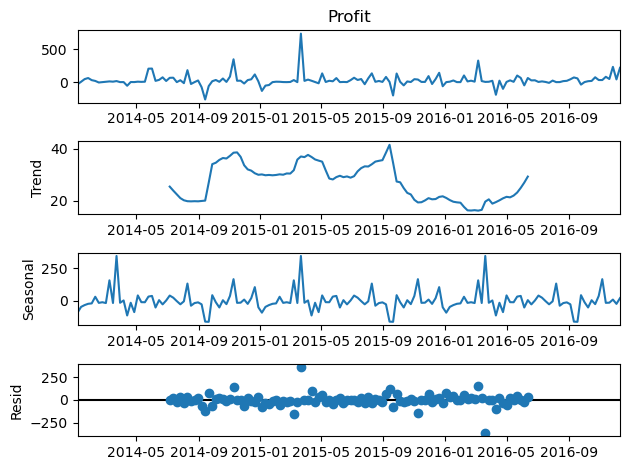

In [8]:
sm.tsa.seasonal_decompose(profit_df.resample('W').mean()).plot()
None

Note:
- Looks synthetic
- Profit spike in march

for col in train.columns:
    plt.figure(figsize=(10,6))
    plt.axhspan(0, train['Profit'].min(), facecolor='red', alpha=0.3)
    plt.axhspan(0, train['Profit'].max(), facecolor='palegreen', alpha=0.3)
    plt.scatter(train[col], train['Profit'], color='#377eb8', label = 'Train', marker = '.')
    plt.legend()
    plt.ylabel('Profit')
    plt.title(col)
    plt.show()

In [9]:
train.columns

Index(['Customer ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Segment',
       'Country', 'City', 'State', 'Postal Code', 'Sales', 'Quantity',
       'Discount', 'Profit', 'Category', 'Sub-Category', 'Customer Name',
       'Product Name', 'Region Name', 'Sales Total', 'Profitable'],
      dtype='object')

In [10]:
target_column = 'Profitable'
target_col = 'Profit'

In [11]:
def t_test_cats(train, target_column, alpha = 0.05):
    """
    Input DataFrame and a string of the target_column name.
    Performs chi^2 test with a default alpha of 0.05 on each categorical feature.
    Prints a visualization and list of columns whos data occures exclusivly 
    in the target group or non-target group.
    """

    #Lists to hold variables
    distros = []
    drivers = []
    non_drivers = []
    t_test_result = []
    
    #This snags int columns and drops those that have more than 2 values.
    plot_df = train.select_dtypes(exclude=['object', 'bool', 'datetime'])
    
    #Seperating target rows
    target_df = plot_df[plot_df[target_column] == 1]

    #Warning that the below is prefered... IDK why:
    #df.loc[:,('one','second')]
    target_df.drop(columns=target_column, inplace = True)
    
    #Seperating non-target rows
    not_target = plot_df[plot_df[target_column] == 0]
    not_target.drop(columns=target_column, inplace = True)
    
    #Creating the Target Indication DataFrame

    for item in target_df:
        target = round(target_df[item].mean(),3)
        not_tar = round(not_target[item].mean(),3)
        if item == 'UDI':
            pass
        else:
            output = {"Column" : item,
                      "Target %": target, 
                      "Not Target %": not_tar,
                      "Target Indication":(target - not_tar)}

            distros.append(output)

    #This turns the info into a DataFrame
    distro_df = pd.DataFrame(distros)              
    distro_df = distro_df.set_index('Column')

    #Seperate out columns to investigate, Target Indication = 1 or -1

    for feature in distro_df.T:

    # Let's run a chi squared to compare proportions, to have more confidence
        null_hypothesis = f'{feature} and {target_column} have no difference in means.'
        alternative_hypothesis = f'there is a difference in means between {feature} and {target_column}'

        #Stats test
        t_stat, p_value = stats.ttest_ind(target_df[feature], not_target[feature])

        #Answer logic
        if p_value < alpha:
            t_test_result.append('Different Means')

        else:
            t_test_result.append('Similar Means')
        
    distro_df['t_test_result'] = t_test_result

    
    #Plotting the relationship with the target variable (and stats test result)
    my_range=range(1,len(distro_df.index) + 1)
    hue_colors = {'Different Means': 'green', 'Similar Means':'red'}
    style_order = {'Different Means': 'o', 'Similar Means':'x'}

    plt.figure(figsize=(6,4))
    plt.axvline(0, c='tomato', alpha=.6)

    plt.hlines(y=my_range, xmin=-2500, xmax=500, color='grey', alpha=0.4)
    sns.scatterplot(data=distro_df, x='Target Indication',
                    y=my_range, hue='t_test_result', palette=hue_colors,
                    style='t_test_result', style_order=style_order)
    plt.legend(title='T-test result')

    # Add title and axis names
    plt.yticks(my_range, distro_df.index)
    plt.title(f'Comparison of profitable versus not profitable', loc='center')
    plt.xlabel('T-Statistic')
    plt.ylabel('Feature')
    

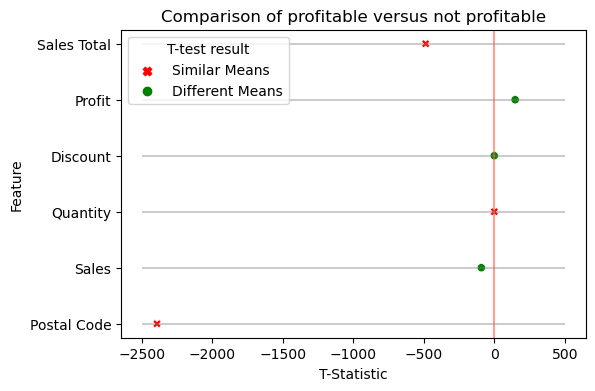

In [12]:
t_test_cats(train, target_column)

In [13]:
def correlation_test(df, target_col, alpha=0.05):
    """
    Maybe create a function that automatically seperates continuous from discrete columns.
    """
    
    list_of_cols = df.select_dtypes(include=[int, float]).columns
              
    metrics = []
    for col in list_of_cols:
        result = stats.anderson(df[col])
        #Checks skew to pick a test
        if (result.statistic < result.critical_values[0]) and (len(df[col]) > 100):
            corr, p_value = stats.pearsonr(df[target_col], df[col])
            test_type = '(P)'
        else:
            # I'm unsure how this handles columns with null values in it.
            corr, p_value = stats.spearmanr(df[target_col],
                                            df[col], nan_policy='omit')
            test_type = '(S)'

        #Answer logic
        if p_value < alpha:
            test_result = 'relationship'
        else:
            test_result = 'independent'
        if col == target_col:
            pass
        else:
            temp_metrics = {"Column":f'{col} {test_type}',
                        "Correlation": corr,
                        "P Value": p_value,
                        "Test Result": test_result}
            metrics.append(temp_metrics)
    distro_df = pd.DataFrame(metrics)              
    distro_df = distro_df.set_index('Column')

    #Plotting the relationship with the target variable (and stats test result)
    my_range=range(1,len(distro_df.index) + 1)
    hue_colors = {'relationship': 'green', 'independent':'red'}

    plt.figure(figsize=(5,4))
    plt.axvline(0, c='tomato', alpha=.6)

    plt.hlines(y=my_range, xmin=-1, xmax=1, color='grey', alpha=0.4)
    sns.scatterplot(data=distro_df, x="Correlation",
                    y=my_range, hue="Test Result", palette=hue_colors,
                    style="Test Result", style_order= hue_colors)
    plt.legend(title="Stats test result")

    # Add title and axis names
    plt.yticks(my_range, distro_df.index)
    plt.title(f'Statistics tests of {target_col}', loc='center')
    plt.xlabel('Neg Correlation            No Correlation            Pos Correlation')
    plt.ylabel('Feature')
    
    #Saves plot when it has a name and uncommented
    #plt.savefig(f'{train.name}.png')


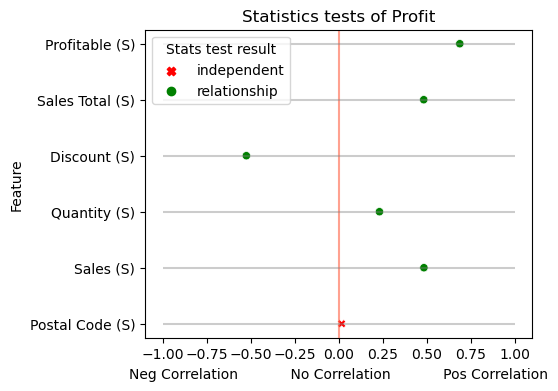

In [14]:
correlation_test(df, target_col)

In [15]:
train.Profit.quantile(q=.75)

28.81244999999999

In [16]:
train[train.Profit > 28.0]['Sub-Category'].value_counts()

Phones         48
Accessories    47
Paper          38
Chairs         32
Appliances     21
Binders        20
Storage        19
Furnishings    18
Tables         16
Envelopes      16
Copiers         8
Labels          8
Machines        8
Bookcases       7
Art             6
Name: Sub-Category, dtype: int64

In [17]:
train[train.Profit > 28.0]['Category'].value_counts()

Office Supplies    128
Technology         111
Furniture           73
Name: Category, dtype: int64

In [18]:
train[train['Sub-Category'] == 'Phones']['Profit'].sum()

5508.287399999998

In [19]:
train[train['Sub-Category'] == 'Accessories']['Profit'].sum()

5401.9708

In [20]:
train[train['Sub-Category'] == 'Paper']['Profit'].sum()

4200.3114000000005

In [21]:
train[train['Category'] == 'Office Supplies']['Profit'].sum()

14143.287499999995

In [22]:
train[train['Category'] == 'Technology']['Profit'].sum()

17219.959499999997

In [23]:
train[train['Category'] == 'Furniture']['Profit'].sum()

-596.527400000004

In [24]:
tech_stuff = train[train['Category'] == 'Technology']

In [25]:
office_stuff = train[train['Category'] == 'Office Supplies']

In [26]:
tech_stuff['Sub-Category'].value_counts()

Phones         106
Accessories     99
Machines        16
Copiers          8
Name: Sub-Category, dtype: int64

In [27]:
office_stuff['Sub-Category'].value_counts()

Binders       177
Paper         156
Storage       120
Art           100
Appliances     47
Labels         46
Envelopes      37
Fasteners      33
Supplies       22
Name: Sub-Category, dtype: int64

In [28]:
tech_stuff[tech_stuff['Sub-Category'] == 'Phones']['Profit'].sum()

5508.287399999998

In [29]:
tech_stuff[tech_stuff['Sub-Category'] == 'Accessories']['Profit'].sum()

5401.9708

In [30]:
tech_stuff[tech_stuff['Sub-Category'] == 'Machines']['Profit'].sum()

2526.278199999998

In [31]:
office_stuff[office_stuff['Sub-Category'] == 'Binders']['Profit'].sum()

3889.4513999999986

In [32]:
office_stuff[office_stuff['Sub-Category'] == 'Paper']['Profit'].sum()

4200.3114000000005

In [33]:
office_stuff[office_stuff['Sub-Category'] == 'Storage']['Profit'].sum()

1445.3633999999995

In [34]:
office_stuff[office_stuff['Sub-Category'] == 'Art']['Profit'].sum()

917.9125999999999

In [35]:
tech_stuff[tech_stuff['Sub-Category'] == 'Phones']['Quantity'].sum()

427.0

In [36]:
tech_stuff[tech_stuff['Sub-Category'] == 'Accessories']['Quantity'].sum()

350.0

In [37]:
tech_stuff[tech_stuff['Sub-Category'] == 'Machines']['Quantity'].sum()

75.0

In [38]:
office_stuff[office_stuff['Sub-Category'] == 'Binders']['Quantity'].sum()

677.0

In [39]:
office_stuff[office_stuff['Sub-Category'] == 'Paper']['Quantity'].sum()

584.0

In [40]:
office_stuff[office_stuff['Sub-Category'] == 'Storage']['Quantity'].sum()

444.0

In [41]:
office_stuff[office_stuff['Sub-Category'] == 'Art']['Quantity'].sum()

372.0

In [42]:
train.Segment.value_counts()

Consumer       692
Corporate      317
Home Office    205
Name: Segment, dtype: int64

In [43]:
train[train.Segment == "Consumer"]['Profit'].sum()

15273.408599999995

In [44]:
train[train.Segment == "Corporate"]['Profit'].sum()

8276.243099999998

In [45]:
train[train.Segment == "Home Office"]['Profit'].sum()

7217.067899999998

In [46]:
train[train.Segment == "Consumer"]['City'].value_counts().head()

New York City    70
Los Angeles      61
Philadelphia     50
San Francisco    34
Houston          33
Name: City, dtype: int64

In [47]:
tech_stuff[tech_stuff['Sub-Category'] == 'Phones']['City'].value_counts().head()

Los Angeles      14
Philadelphia     11
New York City     9
Chicago           6
Houston           5
Name: City, dtype: int64

In [48]:
phones = train[train['Sub-Category'] == 'Phones']
phones.head()

,Customer ID,Order ID,Ship Date,Ship Mode,Segment,Country,City,State,Postal Code,Sales,Quantity,Discount,Profit,Category,Sub-Category,Customer Name,Product Name,Region Name,Sales Total,Profitable
Order Date,,,,,,,,,,,,,,,,,,,,
2014-01-16,DL-13315,CA-2014-115791,2014-01-18,Second Class,Consumer,United States,Philadelphia,Pennsylvania,19134.0,124.200,3.0,0.4,-31.0500,Technology,Phones,Delfina Latchford,AT&T 841000 Phone,East,372.200,0
2014-01-20,HL-15040,US-2014-147627,2014-01-26,Standard Class,Consumer,United States,Jonesboro,Arkansas,72401.0,699.930,7.0,0.0,181.9818,Technology,Phones,Hunter Lopez,Apple iPhone 5C,South,4899.510,1
2014-03-03,AP-10720,CA-2014-127964,2014-03-08,Standard Class,Home Office,United States,New York City,New York,10035.0,9.990,1.0,0.0,4.5954,Technology,Phones,Anne Pryor,PowerGen Dual USB Car Charger,East,9.990,1
2014-04-13,JD-15895,CA-2014-122336,2014-04-17,Second Class,Corporate,United States,Philadelphia,Pennsylvania,19140.0,71.928,12.0,0.4,8.3916,Technology,Phones,Jonathan Doherty,"Square Credit Card Reader, 4 1/2"" x 4 1/2"" x 1...",East,862.736,1
2014-05-11,PG-18895,CA-2014-103849,2014-05-16,Standard Class,Consumer,United States,Fort Worth,Texas,76106.0,100.792,1.0,0.2,6.2995,Technology,Phones,Paul Gonzalez,Xblue XB-1670-86 X16 Small Office Telephone - ...,Central,100.592,1


In [49]:
phones_val = val[val['Sub-Category'] == 'Phones']
phones_val.head()

,Customer ID,Order ID,Ship Date,Ship Mode,Segment,Country,City,State,Postal Code,Sales,Quantity,Discount,Profit,Category,Sub-Category,Customer Name,Product Name,Region Name,Sales Total,Profitable
Order Date,,,,,,,,,,,,,,,,,,,,
2016-12-11,FM-14380,US-2016-135720,2016-12-13,Second Class,Consumer,United States,Aurora,Colorado,80013.0,300.768,4.0,0.2,30.0768,Technology,Phones,Fred McMath,Jabra SPEAK 410,West,1202.872,1
2017-01-14,RB-19570,CA-2017-138779,2017-01-15,First Class,Consumer,United States,Jacksonville,North Carolina,28540.0,7.920,5.0,0.2,0.6930,Technology,Phones,Rob Beeghly,Sannysis Cute Owl Design Soft Skin Case Cover ...,South,39.400,1
2017-01-20,TH-21100,CA-2017-161809,2017-01-26,Standard Class,Consumer,United States,Los Angeles,California,90045.0,160.776,3.0,0.2,10.0485,Technology,Phones,Thea Hendricks,RCA Visys Integrated PBX 8-Line Router,West,482.128,1
2017-01-30,BV-11245,CA-2017-104220,2017-02-05,Standard Class,Corporate,United States,Des Moines,Iowa,50315.0,207.000,3.0,0.0,51.7500,Technology,Phones,Benjamin Venier,AT&T 841000 Phone,Central,621.000,1
2017-02-02,DW-13585,US-2017-164147,2017-02-05,First Class,Corporate,United States,Columbus,Ohio,43229.0,59.970,5.0,0.4,-11.9940,Technology,Phones,Dorothy Wardle,Anker 36W 4-Port USB Wall Charger Travel Power...,East,299.450,0


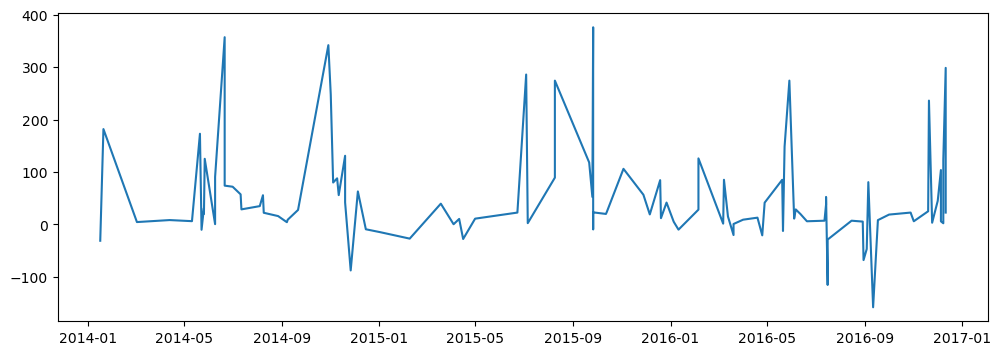

In [50]:
plt.figure(figsize=(12,4))
plt.plot(train[train['Sub-Category'] == 'Phones'].Profit)

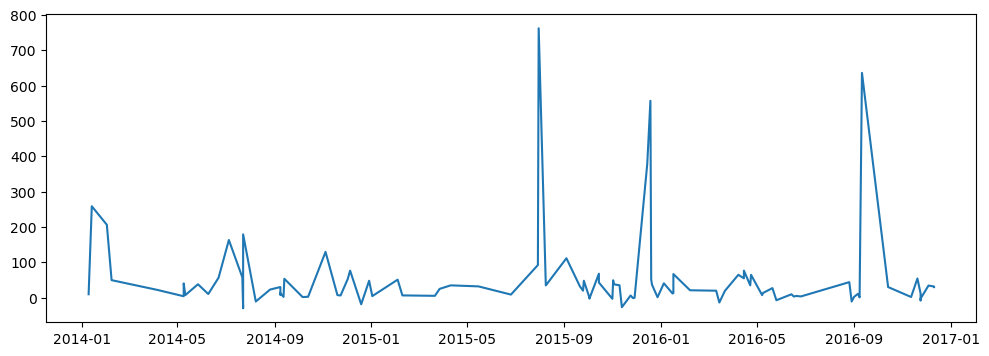

In [51]:
plt.figure(figsize=(12,4))
plt.plot(train[train['Sub-Category'] == 'Accessories']['Profit'])
plt.show()

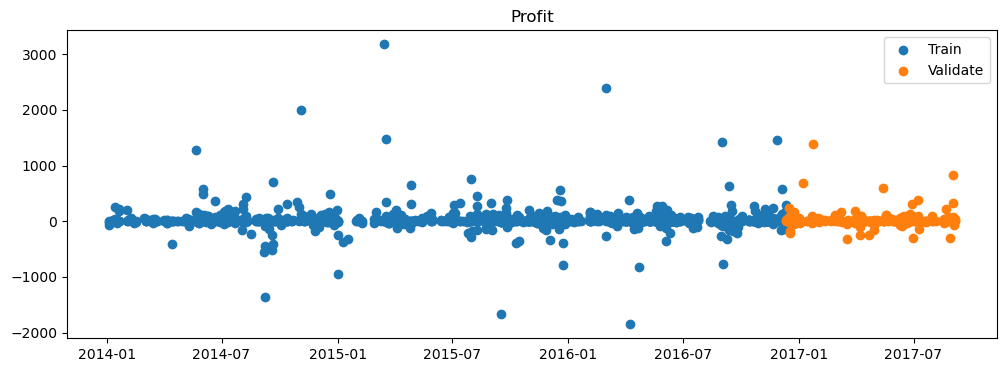

In [52]:
plt.figure(figsize = (12,4))
plt.scatter(x = train.index, y=train['Profit'], label = 'Train')
plt.scatter(x= val.index, y=val['Profit'], label = 'Validate')
plt.title('Profit')

plt.legend()
plt.show()

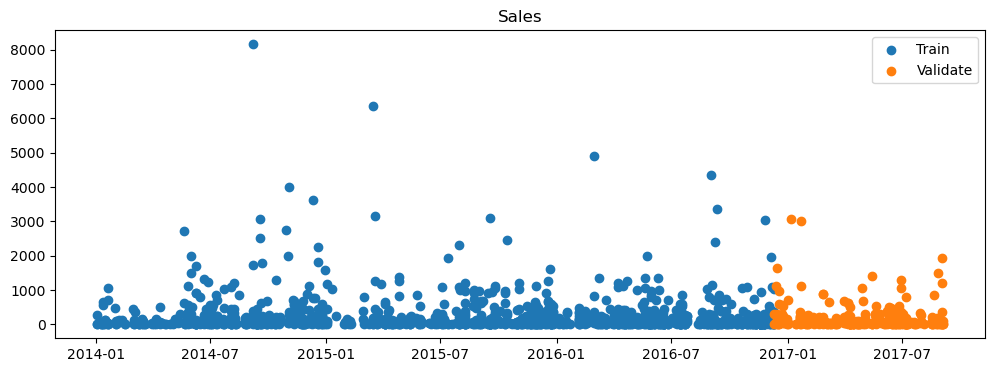

In [53]:
plt.figure(figsize = (12,4))
plt.scatter(x = train.index, y=train['Sales'], label = 'Train')
plt.scatter(x= val.index, y=val['Sales'], label = 'Validate')
plt.title('Sales')

plt.legend()
plt.show()

(array([16071., 16191., 16314., 16436., 16556., 16679., 16801., 16922.,
        17045., 17167.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

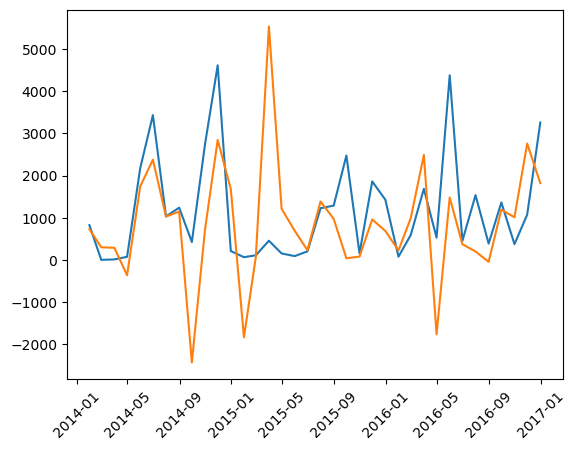

In [54]:
plt.plot(phones.Sales.resample('M').sum())
plt.plot(train.Profit.resample('M').sum())
plt.xticks(rotation = 45)

Text(0, 0.5, 'Dollars')

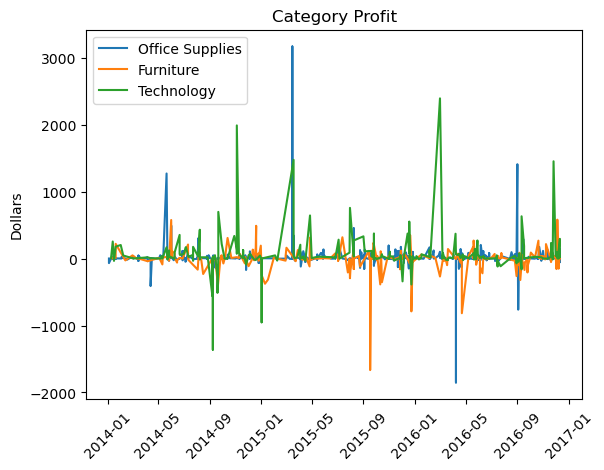

In [61]:
plt.plot(train[train['Category'] == 'Office Supplies']['Profit'], label = 'Office Supplies')
plt.plot(train[train['Category'] == 'Furniture']['Profit'], label = 'Furniture')
plt.plot(train[train['Category'] == 'Technology']['Profit'], label = 'Technology')
plt.xticks(rotation = 45)
plt.legend()
plt.title('Category Profit')
plt.ylabel('Dollars')

17219.959499999997

-596.527400000004